In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from math import sqrt

In [2]:
dataframe = pd.read_csv("C:\\Users\\mrboo.INDRA\\Car Sales.xlsx - car_data.csv")
def quitar_dias(str):
    lista = str.split("/",2)
    return lista[2] + "-" + lista[0]
dataframe["ini_month"] = dataframe["Date"].map(quitar_dias) + "-1"
#print(dataframe["ini_month"])
#dataframe["Date"] = pd.to_datetime(dataframe["Date"])
dataframe["ini_month"] = pd.to_datetime(dataframe["ini_month"])
dataframe.sort_values("ini_month")
agrupacion = dataframe.groupby("ini_month").count()
agruped = agrupacion["Car_id"]

In [13]:
agru = agruped.values
print(len(agru[:24-6]))
print(agruped.index.values)

18
['2022-01-01T00:00:00.000000000' '2022-02-01T00:00:00.000000000'
 '2022-03-01T00:00:00.000000000' '2022-04-01T00:00:00.000000000'
 '2022-05-01T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-07-01T00:00:00.000000000' '2022-08-01T00:00:00.000000000'
 '2022-09-01T00:00:00.000000000' '2022-10-01T00:00:00.000000000'
 '2022-11-01T00:00:00.000000000' '2022-12-01T00:00:00.000000000'
 '2023-01-01T00:00:00.000000000' '2023-02-01T00:00:00.000000000'
 '2023-03-01T00:00:00.000000000' '2023-04-01T00:00:00.000000000'
 '2023-05-01T00:00:00.000000000' '2023-06-01T00:00:00.000000000'
 '2023-07-01T00:00:00.000000000' '2023-08-01T00:00:00.000000000'
 '2023-09-01T00:00:00.000000000' '2023-10-01T00:00:00.000000000'
 '2023-11-01T00:00:00.000000000' '2023-12-01T00:00:00.000000000']


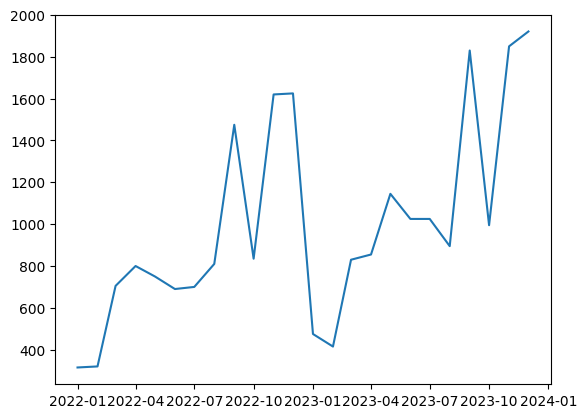

In [34]:

# plot dataset
ply.plot(agruped)
ply.show()

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

lista_agrupados = list(agruped.values)
lista_procesada = series_to_supervised(lista_agrupados)

In [7]:
#función para dividir el conjunto de datos
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

train, test = train_test_split(lista_procesada, 3)
print(test[:,0])
print(test)

[1830.  995. 1850.]
[[1830.  995.]
 [ 995. 1850.]
 [1850. 1921.]]


In [10]:
#nos ayuda a ajustar los datos convertidos por el modelo de regresión de bosque aleatorio
def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

from sklearn.metrics import mean_absolute_error
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, testX)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    error = sqrt(mean_squared_error(test[:, -1], predictions))
    return error, test[:, -1], predictions

error, tested, predicciones = walk_forward_validation(lista_procesada,6)
print(error)

>expected=1025.0, predicted=1097.9
>expected=895.0, predicted=1052.6
>expected=1830.0, predicted=1243.2
>expected=995.0, predicted=797.0
>expected=1850.0, predicted=1043.3
>expected=1921.0, predicted=927.4
584.764655318056


            Car_id  testeados  predicciones
2022-01-01   315.0        NaN           NaN
2022-02-01   320.0        NaN           NaN
2022-03-01   705.0        NaN           NaN
2022-04-01   800.0        NaN           NaN
2022-05-01   750.0        NaN           NaN
2022-06-01   690.0        NaN           NaN
2022-07-01   700.0        NaN           NaN
2022-08-01   810.0        NaN           NaN
2022-09-01  1475.0        NaN           NaN
2022-10-01   835.0        NaN           NaN
2022-11-01  1620.0        NaN           NaN
2022-12-01  1625.0        NaN           NaN
2023-01-01   475.0        NaN           NaN
2023-02-01   415.0        NaN           NaN
2023-03-01   830.0        NaN           NaN
2023-04-01   855.0        NaN           NaN
2023-05-01  1145.0        NaN           NaN
2023-06-01  1025.0        NaN           NaN
2023-07-01     NaN     1025.0   1097.920000
2023-08-01     NaN      895.0   1052.630000
2023-09-01     NaN     1830.0   1243.181667
2023-10-01     NaN      995.0   

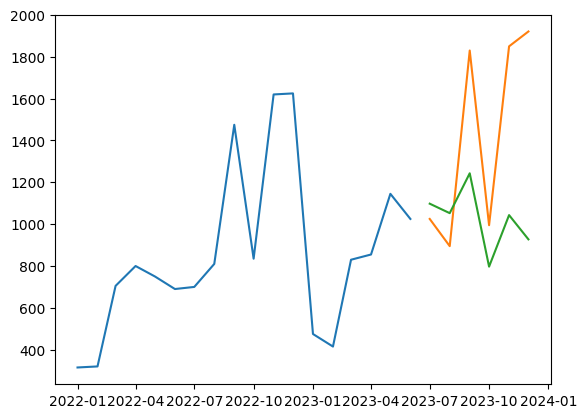

In [16]:
indices = agruped.index.values
df_tested = pd.DataFrame(tested, index = indices[18:], columns=["testeados"])
df_predicciones = pd.DataFrame(predicciones, index = indices[18:], columns=["predicciones"])

total = pd.concat([agruped[:18],df_tested, df_predicciones], axis = 1)

print(total)

ply.plot(total)
ply.show()

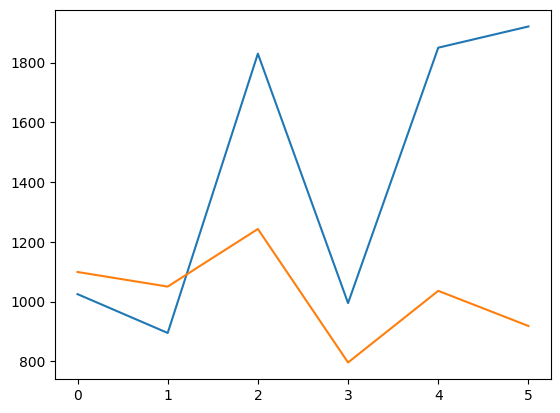

In [39]:
ply.plot(tested)
ply.plot(predicciones)
ply.show()

In [50]:
#lista = pd.concat([train,tested,predicciones],axis=1)
print(type(train), type(tested), type(predicciones))
print(train)
dt1 = pd.DataFrame(train)
print(dt1)
print(len(dt1))
indice = agruped.index.values[:20]
print(len(indice))
dt1.index = indice
print(dt1)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'>
[[ 315.  320.]
 [ 320.  705.]
 [ 705.  800.]
 [ 800.  750.]
 [ 750.  690.]
 [ 690.  700.]
 [ 700.  810.]
 [ 810. 1475.]
 [1475.  835.]
 [ 835. 1620.]
 [1620. 1625.]
 [1625.  475.]
 [ 475.  415.]
 [ 415.  830.]
 [ 830.  855.]
 [ 855. 1145.]
 [1145. 1025.]
 [1025. 1025.]
 [1025.  895.]
 [ 895. 1830.]]
         0       1
0    315.0   320.0
1    320.0   705.0
2    705.0   800.0
3    800.0   750.0
4    750.0   690.0
5    690.0   700.0
6    700.0   810.0
7    810.0  1475.0
8   1475.0   835.0
9    835.0  1620.0
10  1620.0  1625.0
11  1625.0   475.0
12   475.0   415.0
13   415.0   830.0
14   830.0   855.0
15   855.0  1145.0
16  1145.0  1025.0
17  1025.0  1025.0
18  1025.0   895.0
19   895.0  1830.0
20
20
                 0       1
2022-01-01   315.0   320.0
2022-02-01   320.0   705.0
2022-03-01   705.0   800.0
2022-04-01   800.0   750.0
2022-05-01   750.0   690.0
2022-06-01   690.0   700.0
2022-07-01   700.0   810.0
2022-08-01   81

>expected=1025.0, predicted=1145.0
>expected=895.0, predicted=1025.0
>expected=1830.0, predicted=1145.0
>expected=995.0, predicted=475.0
>expected=1850.0, predicted=1830.0
>expected=1921.0, predicted=995.0


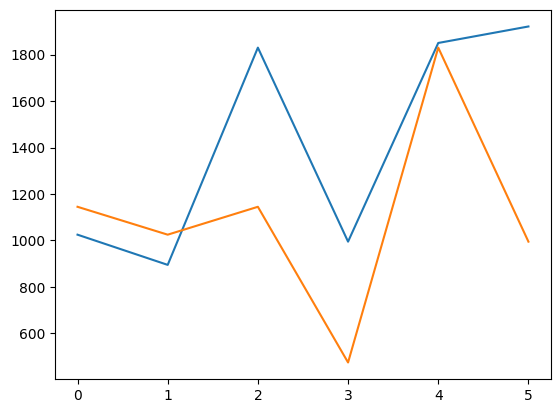

521.024877032309


In [21]:
def xgboost_forecast(train, testX):
 # transform list into array
 train = np.asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict(np.asarray([testX]))
 return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
 predictions = list()
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
 # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
 # fit model on history and make a prediction
    yhat = xgboost_forecast(history, testX)
 # store forecast in list of predictions
    predictions.append(yhat)
 # add actual observation to history for the next loop
    history.append(test[i])
 # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = sqrt(mean_squared_error(test[:, -1], predictions))
 return error, test[:, -1], predictions

error, tested, predicciones = walk_forward_validation(lista_procesada,6)

ply.plot(tested)
ply.plot(predicciones)
ply.show()

print(error)
